In [1]:
import os
import pandas as pd


os.getcwd()

# Define the path to the folder
path = 'RMMS'

# Get a list of all files in the folder
files = [f for f in os.listdir(path) if f.endswith('.lrps.htm')]

# Initialize an empty list to store DataFrames
dfs = []

# Loop through each file
for file in files:
    # Read HTML tables into a list of DataFrames
    tables = pd.read_html(os.path.join(path, file))

    # Combine all tables into a single DataFrame
    df = pd.concat(tables)

    # Remove the first row and rows above row 9
    df = df.iloc[9:].reset_index(drop=True)

    # Set the correct header using the values from row 9
    df.columns = df.iloc[0]

    # Drop the now redundant row 9
    df = df.iloc[1:].reset_index(drop=True)

    # Drop the first and last columns
    df = df.iloc[:, 1:-1]

    # Add a new column for road number
    road_number = file.split('.')[0]  # Extract road number from file name
    df['road_number'] = road_number

    # Append the DataFrame to the list
    dfs.append(df)

# Concatenate all DataFrames into one
combined_df = pd.concat(dfs, ignore_index=True)

# Save the combined DataFrame to a CSV file
combined_df.to_csv('combined_lrps.csv', index=False)


In [2]:
combined_df.shape
combined_df.to_csv('RMMS/combined_lrps.csv', index=False)

In [3]:
import pandas as pd

traffic_df = pd.read_csv('traffic.csv')
traffic_df.head()

,road,name,LRP,Offset,Chainage,LRP_end,Óffset_end,Chainage_end,(Km),Heavy Truck,...,Car,Auto Rickshaw,Motor Cycle,Bi-Cycle,Cycle Rickshaw,Cart,Motorized,Non Motorized,Total AADT,(AADT)
0,N1,Jatrabari - Int.with Z1101,LRPS,0,0.000,LRPS,822,0.822,0.822,531.0,...,2229.5,2744.0,417.0,222.5,988.5,0.0,19236.0,1211.0,20447.0,20447.0
1,N1,Int.with Z1101 - Signboard R111,LRPS,822,0.822,LRPS,4175,4.175,3.353,531.0,...,2229.5,2744.0,417.0,222.5,988.5,0.0,19236.0,1211.0,20447.0,20447.0
2,N1,Signboard - Shimrail R110,LRPS,4175,4.175,LRPS,7181,7.181,3.006,88.0,...,1649.5,2211.5,1061.0,73.5,1169.0,0.0,15866.5,1242.5,17109.0,17109.0
3,N1,Shimrail - Katchpur N2,LRPS,7181,7.181,LRP009,260,8.763,1.582,163.5,...,1763.5,2923.5,1152.5,364.0,1304.0,0.0,15998.5,1668.0,17666.5,17666.5
4,N1,Katchpur - Madanpur N105,LRP009,260,8.763,LRP012,439,11.936,3.173,163.5,...,1842.0,3117.0,1148.5,364.0,1304.0,0.0,22566.0,1668.0,24234.0,24234.0


In [4]:
traffic_df= traffic_df.rename(columns = { 'LRP':'LRP Start', 'Offset': 'Offset Start', 'Chainage':'Chainage Start', 'LRP.1':'LRP End', 'Offset.1': 'Offset End', 'Chainage.1':'Chainage End'})
print(traffic_df.shape)


(1993, 26)


In [5]:
# Combining the different dataframes into one so we have the lat/lon values combined with the AADT values so we can calculate the different economic values for the road parts.  
combined_lrps = pd.read_csv('combined_lrps.csv')

latlonload = pd.merge(traffic_df, combined_lrps, left_on=['LRP Start','road'], right_on=['LRP No', 'road_number'] )

In [6]:
#When merging we got 3 rows of each entry, we have dropped the duplicates below to ensure we do not get double entries.
latlonload = latlonload.drop_duplicates()

In [7]:
#To calculate the economic value of a roadpart, we have to assign economic value to different vehicle types. Afterwards we will multiply these values with the amount of sightings on each road to compute the economic value of a road. The logic behind the values is that for example trucks are able to carry a lot of goods, busses a lot of people and smaller vehicles are more individual focussed, hence the smaller economic impact. It should be noted that these are all estimates as we were unable to find research on the marginal economic impact of these vehicle types. 

# Define economic value vehicles dictionary
economic_value_vehicles = {'Heavy Truck':10, 'Medium Truck': 8, 'Small Truck':7, 'Large Bus':7, 'Medium Bus':6,
                           'Micro Bus':5, 'Utility':3, 'Car':3, 'Auto Rickshaw':2, 'Motor Cycle': 1,
                           'Bi-Cycle':0.5, 'Cycle Rickshaw':1, 'Cart':1}

# Drop rows containing 'NS' values because there were rows with only NS values where floats were supposed to be.
latlonload = latlonload[~latlonload.apply(lambda row: (row == 'NS').any(), axis=1)]

# Select columns relevant for economic calculation
economic_df = latlonload.loc[:, 'Heavy Truck':'Cart']

# Define a function to check if a value can be converted to float, this was used to find the NS values 
def is_float(x):
    try:
        float(x)
        return True
    except ValueError:
        return False

# Apply the function to each element of the DataFrame
for col in economic_df.columns:
    non_numeric_values = economic_df[col][~economic_df[col].apply(is_float)]
    if not non_numeric_values.empty:
        print(f"Non-numeric values in column '{col}':")
        print(non_numeric_values)




In [8]:
# Convert values to floats
economic_df = economic_df.astype(float)

# Calculate the economic value for each row
latlonload['EVV'] = economic_df.apply(lambda row: sum(row[col] * economic_value_vehicles[col] for col in economic_df.columns if col in economic_value_vehicles), axis=1)

latlonload.tail(10)

,road,name,LRP Start,Offset Start,Chainage Start,LRP_end,Óffset_end,Chainage_end,(Km),Heavy Truck,...,Total AADT,(AADT),LRP No,Road Chainage,LRP TYPE,Description,Latitude Decimal,Longitued Decimal,road_number,EVV
2328,Z8806,Dumki(int.with Z8044)-Bauphal(int.with Z8910),LRPS,2858,2.858,LRPS,24312,24.312,21.454,0.0,...,2242.0,2242.0,LRPS,0,Others,Start of Road from N8 infornt of Patuakhali Sc...,22.4536667,90.3410552,Z8806,4315.0
2334,Z8806,Kalaiya (Int.with Z8052)-Amragachia(int.with R...,LRP027,2140,28.656,LRPE,0,86.377,57.721,0.0,...,1307.0,1307.0,LRP027,26.516,Km Post,Information Not Clear,22.4074722,90.5713604,Z8806,1463.0
2337,Z8815,Amua-Safa,LRPS,0,0.000,LRPS,13057,13.057,13.057,0.0,...,1941.0,1941.0,LRPS,0,Others,"Start of road from Amua Bazar ,Zhalokati.",22.35875,90.075416,Z8815,2191.0
2340,Z8905,Udypur (Int.with R890) - Tazumuddin (Int.with ...,LRPS,0,0.000,LRP003,10700,13.000,13.000,0.0,...,1923.0,1923.0,LRPS,0,Others,Start of road from R 890 at Udypur (Teenmatha)...,22.4862774,90.7690549,Z8905,3764.5
2343,Z8905,Tazumuddin (Int.with Z8943) - Sikdarhat,LRP003,10700,13.000,LRP003,35700,38.000,25.000,0.0,...,1201.0,1201.0,LRP003,2.3,Km Post,Information missing,22.4913886,90.7908052,Z8905,2377.0
2346,Z8909,Char Fession (Int.with R890) - Betua,LRPS,0,0.000,LRP006,952,7.002,7.002,0.0,...,3991.0,3991.0,LRPS,0,Others,Start from R890 at Thana road more char fassion,22.185833,90.76025,Z8909,5192.5
2349,Z8916,Guingerhat (Int.with R890) - Int.with Z8915,LRPS,0,0.000,LRP004,3626,7.626,7.626,0.0,...,2440.0,2440.0,LRPS,0,Others,Start from R890 at Guingerhat Bazar Dhola,22.6254993,90.6617222,Z8916,3553.5
2352,Z8916,Int.with Z8915 - Daulatkhan Bazar,LRP004,3626,7.626,LRP005,6600,11.591,3.965,0.0,...,2440.0,2440.0,LRP004,4,Km Post,Information missing,22.6189716,90.6941108,Z8916,3553.5
2355,Z8943,Tazumuddin (Int.with Z8905) - Fakirhat (Int.wi...,LRPS,0,0.000,LRPS,6446,6.446,6.446,0.0,...,3083.0,3083.0,LRPS,0,Others,Start at intersection of Z8905 /BC joint infro...,22.4264438,90.8494719,Z8943,5651.0
2358,Z8943,Fakirhat (Int.with Z8948) - Kungerhat (Int.wit...,LRPS,6446,6.446,LRPS,8800,8.800,2.354,0.0,...,3083.0,3083.0,LRPS,0,Others,Start at intersection of Z8905 /BC joint infro...,22.4264438,90.8494719,Z8943,5651.0


In [9]:
latlonload = latlonload.rename(columns={'Longitued Decimal':'Longitude Decimal'})
latlonload.sort_values('EVV', ascending=False).head(10)


,road,name,LRP Start,Offset Start,Chainage Start,LRP_end,Óffset_end,Chainage_end,(Km),Heavy Truck,...,Total AADT,(AADT),LRP No,Road Chainage,LRP TYPE,Description,Latitude Decimal,Longitude Decimal,road_number,EVV
15,N1,Madanpur - Langalband Z1061,LRP012,439,11.936,LRP013,3411,15.935,3.999,163.5,...,24234.0,24234.0,LRP012,11.497,Km Post,"Chittagong 248 km,Comilla 81 km",23.6918052,90.5426108,N1,126461.00
18,N1,Langalband - Mograpara Chowrasta Z1089,LRP013,3411,15.935,LRP013,7520,20.044,4.109,163.5,...,24234.0,24234.0,LRP013,12.524,Km Post,"Ctg 247 km,Comilla 80 km",23.6865274,90.5504167,N1,126461.00
12,N1,Katchpur - Madanpur N105,LRP009,260,8.763,LRP012,439,11.936,3.173,163.5,...,24234.0,24234.0,LRP009,8.503,Km Post,"Chittagong 251 km,Comilla 84 km",23.7050278,90.5193327,N1,126461.00
297,N303,Churkhai Bazar-Intersection with N3,LRPS,0,0.000,LRPS,1009,1.009,1.009,289.0,...,28352.0,28352.0,LRPS,0,Others,The Road starts from N3 before Churkhai Bazar,24.6712771,90.4035833,N303,124984.00
0,N1,Jatrabari - Int.with Z1101,LRPS,0,0.000,LRPS,822,0.822,0.822,531.0,...,20447.0,20447.0,LRPS,0,Others,Start of Road after Jatrabari Flyover infront ...,23.7060278,90.443333,N1,111888.75
3,N1,Int.with Z1101 - Signboard R111,LRPS,822,0.822,LRPS,4175,4.175,3.353,531.0,...,20447.0,20447.0,LRPS,0,Others,Start of Road after Jatrabari Flyover infront ...,23.7060278,90.443333,N1,111888.75
306,N406,Start form N4 near IT park Gate-int.with R315,LRPS,0,0.000,LRPS,2802,2.802,2.802,37.0,...,16456.0,16456.0,LRPS,0,Others,The road starts from N4 near IT park Gate,23.9894163,90.2247493,N406,95484.50
312,N407,Korotia(Int.with N408)-Bangra(Int.with Z4012),LRPS,0,0.000,LRPE,0,2.206,2.206,37.0,...,16456.0,16456.0,LRPS,0,Others,The road starts from N408 at Karatia Bazar,24.2223049,89.9781104,N407,95484.50
105,N1,Barabkunda Z1087-Fouzderhat Z1016,LRP209,486,206.402,LRP225,6400,228.406,22.004,1101.5,...,15291.0,15291.0,LRP209,205.916,Km Post,Info.Missing,22.584583,91.6780827,N1,89902.50
102,N1,Baroirdala Z1086- Barabkunda Z1087,LRP197,1120,194.603,LRP209,486,206.402,11.799,1101.5,...,15291.0,15291.0,LRP197,193.483,Km Post,"Ctg 48 km,Sitakanda 8 km",22.6825549,91.6241938,N1,89902.50


In [10]:
latlonload.describe()


,Offset Start,Chainage Start,Óffset_end,Chainage_end,(Km),EVV
count,662.000000,662.000000,662.000000,662.000000,662.000000,662.000000
mean,1181.170695,53.736698,2739.043807,63.978293,10.241595,20090.442221
std,3050.733142,99.540647,5069.869258,99.220063,9.236668,22556.455612
min,0.000000,0.000000,0.000000,0.400000,0.326000,662.000000
25%,0.000000,0.000000,376.500000,9.396500,3.310750,5289.500000
50%,267.500000,6.930500,924.500000,22.511000,7.687500,11193.250000
75%,955.250000,51.203750,2635.250000,62.865250,14.278750,25481.375000
max,38564.000000,495.369000,51184.000000,526.033000,61.699000,126461.000000


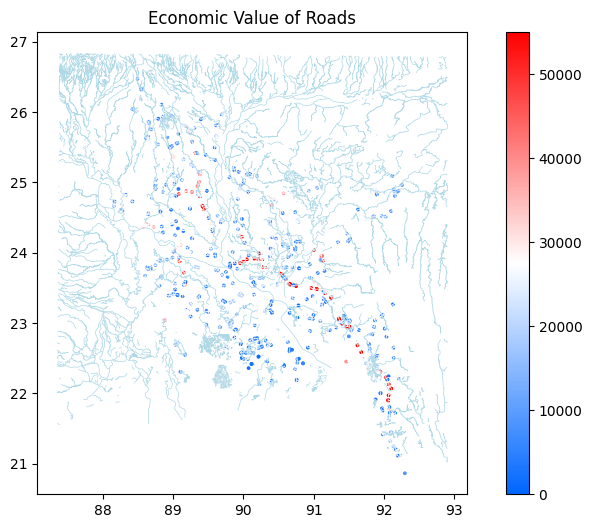

In [11]:
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# Load the shapefile of Bangladesh roads
roads = gpd.read_file("osm/roads.shp")

# Load the shapefile of waterways
waterways = gpd.read_file("osm/waterways.shp")

# Convert latitude and longitude columns to numeric types, handling errors
latlonload['Latitude Decimal'] = pd.to_numeric(latlonload['Latitude Decimal'], errors='coerce')
latlonload['Longitude Decimal'] = pd.to_numeric(latlonload['Longitude Decimal'], errors='coerce')

# Define a small range around lat/lon 0/0
tolerance = 0.01

# Remove rows with latitude and longitude values close to 0/0
latlonload = latlonload[
    (latlonload['Latitude Decimal'].abs() > tolerance) &
    (latlonload['Longitude Decimal'].abs() > tolerance)
]

# Create a GeoDataFrame from the filtered latlonload DataFrame
gdf = gpd.GeoDataFrame(latlonload, geometry=gpd.points_from_xy(latlonload['Longitude Decimal'], latlonload['Latitude Decimal']))

# Define a colormap for the economic value of roads
cmap = LinearSegmentedColormap.from_list('evv', ['#0066ff', '#ffffff', '#ff0000'])

# Plot the map of Bangladesh roads
ax = roads.plot(color='white', edgecolor='black', figsize=(10, 6), linewidth=0.5)

# Plot the waterways with adjusted parameters
waterways.plot(ax=ax, color='lightblue', linewidth=0.5)

# Plot the data points with the defined colormap
gdf.plot(ax=ax, marker='o', markersize=3, column='EVV', cmap=cmap, legend=True, vmin=0, vmax=55000)

# Add title
plt.title('Economic Value of Roads')

# Show plot
plt.show()


In [12]:
latlonload.to_csv('latlonloads.csv')


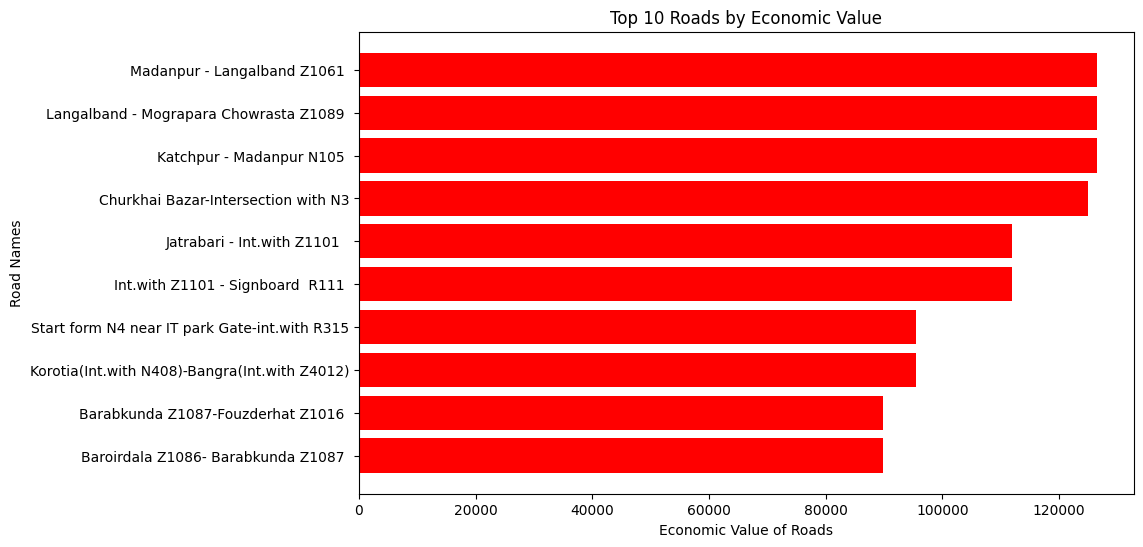

In [13]:
import matplotlib.pyplot as plt

# Sort the DataFrame based on 'EVV' column in descending order
sorted_latlonload = latlonload.sort_values('EVV', ascending=False)

# Get the top N roads (e.g., top 10)
top_n = 10
top_n_df = sorted_latlonload.head(top_n)

# Extract road names and EVV values for plotting
road_names = top_n_df['name']
evv_values = top_n_df['EVV']

# Plot the bar chart
plt.figure(figsize=(10, 6))
plt.barh(road_names, evv_values, color='red')
plt.xlabel('Economic Value of Roads')
plt.ylabel('Road Names')
plt.title(f'Top {top_n} Roads by Economic Value')
plt.gca().invert_yaxis()  # Invert y-axis to display the highest-ranking road at the top
plt.show()


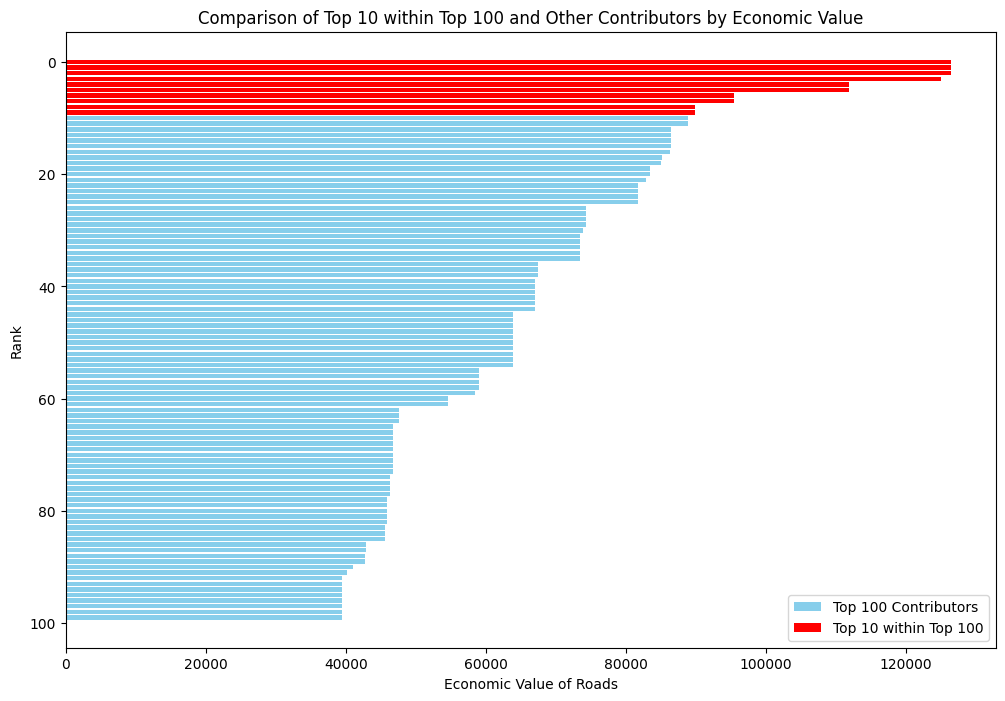

In [14]:
import matplotlib.pyplot as plt

# Sort the DataFrame based on 'EVV' column in descending order
sorted_latlonload = latlonload.sort_values('EVV', ascending=False)

# Get the top 100 roads
top_100_df = sorted_latlonload.head(100)

# Get the 10 highest contributors within the top 100
top_10_within_100 = top_100_df.head(10)

# Plot the bar chart for top 100 contributors in blue
plt.figure(figsize=(12, 8))
plt.barh(range(len(top_100_df)), top_100_df['EVV'], color='skyblue', label='Top 100 Contributors')

# Highlight top 10 contributors within top 100 in red
plt.barh(range(len(top_10_within_100)), top_10_within_100['EVV'], color='red', label='Top 10 within Top 100')

plt.xlabel('Economic Value of Roads')
plt.ylabel('Rank')
plt.title('Comparison of Top 10 within Top 100 and Other Contributors by Economic Value')
plt.legend()
plt.gca().invert_yaxis()  # Invert y-axis to display the highest-ranking road at the top
plt.show()


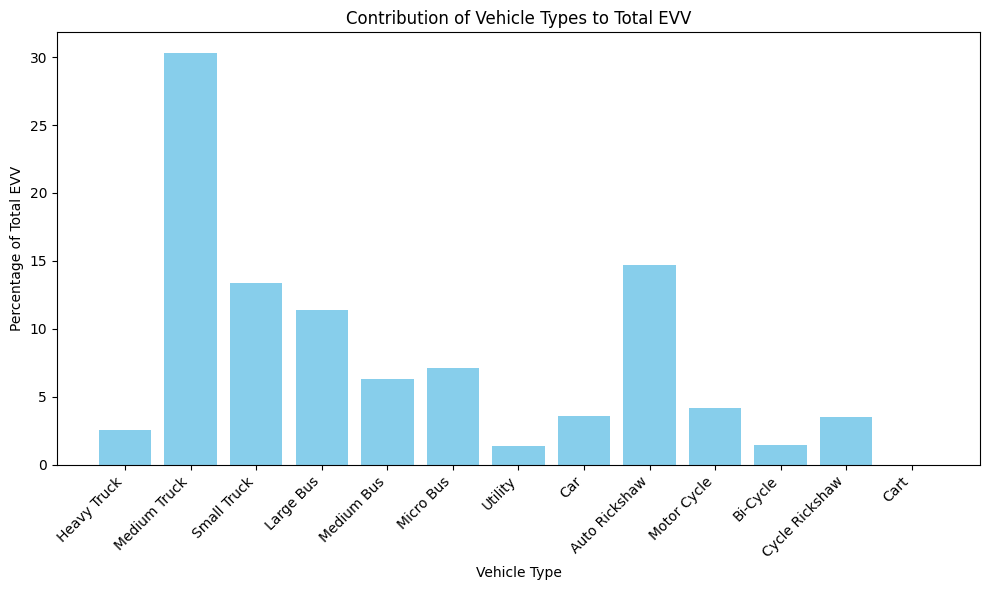

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

# Define economic value of vehicles
economic_value_vehicles = {
    'Heavy Truck': 10, 'Medium Truck': 8, 'Small Truck': 7, 'Large Bus': 7,
    'Medium Bus': 6, 'Micro Bus': 5, 'Utility': 3, 'Car': 3, 'Auto Rickshaw': 2,
    'Motor Cycle': 1, 'Bi-Cycle': 0.5, 'Cycle Rickshaw': 1, 'Cart': 1
}

# Ensure the data types in latlonload are numeric
latlonload = latlonload.apply(pd.to_numeric, errors='coerce')

# Calculate the total EVV for each vehicle type
total_evv_per_vehicle = {}
for vehicle, value in economic_value_vehicles.items():
    total_evv_per_vehicle[vehicle] = latlonload[vehicle].sum() * value

# Create a DataFrame from the dictionary
df_total_evv_per_vehicle = pd.DataFrame(total_evv_per_vehicle.items(), columns=['Vehicle', 'Total EVV'])

# Calculate the total EVV
total_evv = df_total_evv_per_vehicle['Total EVV'].sum()

# Calculate the percentage contribution of each vehicle type
df_total_evv_per_vehicle['Percentage'] = (df_total_evv_per_vehicle['Total EVV'] / total_evv) * 100

# Plot the contribution of each vehicle type to the total EVV
plt.figure(figsize=(10, 6))
plt.bar(df_total_evv_per_vehicle['Vehicle'], df_total_evv_per_vehicle['Percentage'], color='skyblue')
plt.xlabel('Vehicle Type')
plt.ylabel('Percentage of Total EVV')
plt.title('Contribution of Vehicle Types to Total EVV')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()
